Sources:
- RNN Simple example: https://medium.com/@praveenraj.gowd/understanding-recurrent-neural-networks-rnn-nlp-e2f4cae03a4f
- Backward pass and Vanishing/exploding gradient theory: https://mmuratarat.github.io/2019-02-07/bptt-of-rnn

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F 
from IPython.display import Image

# Introduction to Recurrent Neural Networks

In this section I present the formulas and develop two simple models with the aim to explain the backward and forward pass in recurrent neural networks (vanilla RNN) and the calculations performed by the PyTorch `nn.RNN` module. Two examples were developed to train models with RNN that predict repetitive sequences, regression tasks: the $\sin(x)$ function and a combined signal. 

### Forward Pass in RNN

For the forward pass in the RNN, the key equations are:

1. **Hidden State Update** at time step $ t $:
   $$
   h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
   $$
   
2. **Output** at time step $ t $:
   $$
   o_t = W_{hy} \cdot h_t + b_y
   $$
   $$
   \hat{y_t} = \phi_t(o_t)
   $$

Where:

- $m$, number of instances in the minibatch
- $n_{inputs}$, number of input features
- $n_{neurons}$, also called number of hidden units of the hidden layer-state (a hyperparameter)



- $h_t$ is the current Hidden State
- $\phi_t$ the activation function(softmax, ReLU, etc.)
- $x_{t}$ is an $m \times n_{inputs}$ matrix containing the inputs for all instances
- $h_{t-1}$ is an $m \times n_{neurons}$ matrix containing the hidden state of the previous time-step for all instances
- $W_{xh}$ is an $n_{inputs} \times n_{neurons}$ matrix containing the connection weights between input and the hidden layer
- $W_{hh}$ is an $n_{neurons} \times n_{neurons}$ matrix containing the connection weights between two hidden layers
- $W_{yh}$ is an $n_{neurons} \times n_{outputs}$ matrix containing the connection weights between the hidden layer of the output
- $b_{h}$ is a vector of size $n_{neurons}$ containing each neuron's bias term
- $b_{y}$ is a vector of size $n_{neurons}$ containing each output's bias term
- $y_{t}$ is a vector of size $n_{neurons}$ containing the target vector



A full description and derivations of the gradients can be found in the Backward pass and Vanishing/exploding gradient theory source.

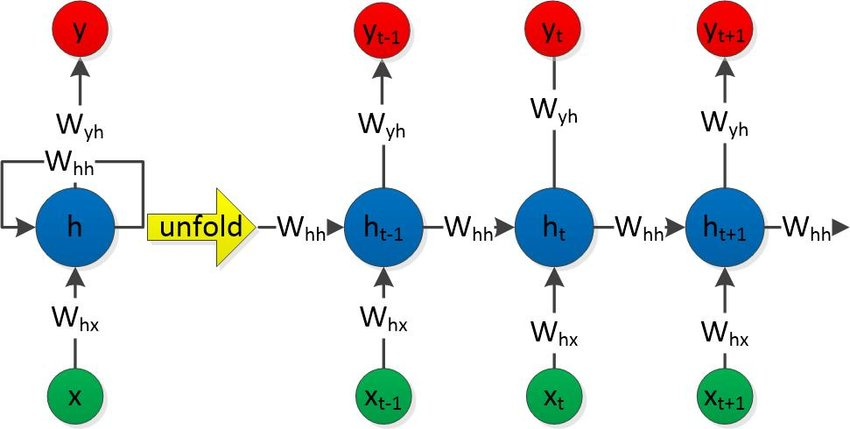

In [4]:
Image("images/RNN.png")

### 
The next code depicts how to perform a **single** forward and backward pass for classification task in vanilla RNNs using random pytorch tensors. This description will be used to create A *manual model*.

In [15]:
# reproducibility 
torch.manual_seed(101)

# define the input sequence length, hidden size, and input size
seq_length = 5 # time steps (sequence length)
input_size = 3 # input feature size (n_inputs)
hidden_size = 5 # hidden state size (number of hidden units of the hidden layer-state, n_neurons) 
output_size = 2 # output size

# create random inputs 
x = torch.randn(seq_length, input_size, requires_grad=True)

# initialize weights and biases for the RNN with requires_grad=True
W_xh = torch.randn(input_size, hidden_size, requires_grad=True) #weights for input to hidden
W_hh = torch.randn(hidden_size, hidden_size, requires_grad=True) #weights for hidden to hidden
b_h = torch.randn(hidden_size, requires_grad=True) #bias for hidden state

# initialize weights and biases for the output layer
W_hy = torch.randn(hidden_size, output_size, requires_grad=True) #weights for hidden to output
b_y = torch.randn(output_size, requires_grad=True) # Bias for output

# initialize the hidden state
h_t = torch.zeros(hidden_size, requires_grad=True)

# the entire forward pass through time, this is through all the length of the sequence (RNN loop)
outputs = []
for t in range(seq_length):
    x_t = x[t] # input at time step t
    h_t = torch.tanh(x_t @ W_xh + h_t @ W_hh + b_h) # raw output at time step t
    o_t = h_t @ W_hy + b_y # raw output at time step t
    y_hat_t = F.softmax(o_t, dim=0) # appy softmax to get prob distribution (no needed for regression task)
    outputs.append(y_hat_t)
    
# convert list of outputs to tensor (for further loss calculation)
outputs = torch.stack(outputs)

# define a dummy target (same shape as output for the loss)
target = torch.randn(seq_length, output_size)

# compute the loss (mean squared error)
loss = torch.mean((outputs - target) ** 2)

# backward pass (compute gradients)
loss.backward()

# Display gradients for each of the parameters
print("Shape of Gradients for W_xh:", W_xh.shape)
print("Shape of Gradients for W_hh:", W_hh.shape)
print("Shape of Gradients for b_h:", b_h.shape)
print("Shape of Gradients for W_hy:", W_hy.shape)
print("Shape of Gradients for b_y:", b_y.shape)
print("Outputs", outputs)

Shape of Gradients for W_xh: torch.Size([3, 5])
Shape of Gradients for W_hh: torch.Size([5, 5])
Shape of Gradients for b_h: torch.Size([5])
Shape of Gradients for W_hy: torch.Size([5, 2])
Shape of Gradients for b_y: torch.Size([2])
Outputs tensor([[0.1527, 0.8473],
        [0.9690, 0.0310],
        [0.9808, 0.0192],
        [0.1314, 0.8686],
        [0.1580, 0.8420]], grad_fn=<StackBackward0>)


## Example 1
In this example a model for a regression task is developed using a manual RNN and the PyTorch `nn.Module` with the goal of predicting a part of the $\sin(x)$ function.

### Creating the dataset for a regression task
For both models the tensor X represents a series of input sequences. Each sequence in X is a window of `seq_lenth` consecutive wave values, and the tensor Y represents the next value that follows each sequence in X.

By using sequences as input, we're teaching the RNN to understand the pattern and context of the sine wave over time. This approach allows the model to potentially capture more complex patterns than just learning a static function.

The `create_dataset` function creates these overlapping sequences from the original sine wave data.
Each $X[i]$ is a sequence of `seq_lenth` values, and the corresponding $Y[i]$ is the `seq_lenth + 1` value, the next value of the sequence.

In [2]:
# Set random seed for reproducibility
torch.manual_seed(101)

# Parameters
seq_length = 50  # Length of input sequence (those are the number of "time steps")
input_size = 1   # Since we're predicting wave values, one feature
hidden_size = 10 # Size of hidden layer
output_size = 1  # Predicting a single value (wave)

# Generate sine wave data
x = np.linspace(0, 100, 1000)
y = np.sin(x)

# Prepare dataset
def create_dataset(data, seq_length, test_split=0):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        Y.append(data[i + seq_length])
    
    X, Y = np.array(X), np.array(Y)
    
    if test_split > 0:
        split_index = int(len(X) * (1 - test_split))
        X_train, X_val = X[:split_index], X[split_index:]
        Y_train, Y_val = Y[:split_index], Y[split_index:]
        return X_train, Y_train, X_val, Y_val
    else:
        return X, Y

X, Y = create_dataset(y, seq_length)

# reshaping for pytorch rnn layer
X = torch.tensor(X, dtype=torch.float32).view(-1, seq_length, input_size)

# one predicted value for each input sequence
Y = torch.tensor(Y, dtype=torch.float32).view(-1, output_size)

### Manual model definition
The "recurrent" part of RNNs occurs in the for loop inside the forward method when the previous $h_t$ is used in the next time step, and this happens for all time steps. This forward method returns the entire predictions for the last time step $h_{tf}$ but since it's a regression task it can return only the last element of the prediction without problem.

In [7]:
# manual RNN
class ManualRNN:
    def __init__(self):
        # initialize weights and biases
        self.W_xh = torch.randn(input_size, hidden_size, requires_grad=True)  # weights for input to hidden
        self.W_hh = torch.randn(hidden_size, hidden_size, requires_grad=True)  # weights for hidden to hidden
        self.b_h = torch.randn(hidden_size, requires_grad=True)  # bias for hidden state
        self.W_hy = torch.randn(hidden_size, output_size, requires_grad=True)  # weights for hidden to output
        self.b_y = torch.randn(output_size, requires_grad=True)  # bias for output
    
    def forward(self, x):
        h_t = torch.zeros(hidden_size)  # initialize hidden state
        outputs = []
        for t in range(seq_length):
            x_t = x[t]  # Input at time step t
            h_t = torch.tanh(x_t @ self.W_xh + h_t @ self.W_hh + self.b_h)  # Update hidden state
            o_t = h_t @ self.W_hy + self.b_y  # Output
            outputs.append(o_t)
        return torch.stack(outputs)

### Manual model training loop
Since the forward method of the model returns the entire output in each forward pass we only select as optimizer parameter the last element of this output.

In [10]:
# Training parameters
learning_rate = 0.01
epochs = 50
manual_model = ManualRNN()

# Training loop
for epoch in range(epochs):
    for i in range(X.size(0)):
        x_t = X[i]
        y_t = Y[i]
        
        # Forward pass
        outputs = manual_model.forward(x_t)
        loss = nn.MSELoss()(outputs[-1], y_t)  # Use the last output for prediction
        
        # Backward pass
        loss.backward()
        
        # Update weights (gradient descent)
        with torch.no_grad():
            for param in [manual_model.W_xh, manual_model.W_hh, manual_model.b_h, manual_model.W_hy, manual_model.b_y]:
                param -= learning_rate * param.grad
                param.grad = None  # Reset gradients
    
    if epoch % 2 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.0654832050204277
Epoch 2, Loss: 0.10192542523145676
Epoch 4, Loss: 0.011447761207818985
Epoch 6, Loss: 0.0053053018637001514
Epoch 8, Loss: 0.0018586891237646341
Epoch 10, Loss: 0.012121793814003468
Epoch 12, Loss: 0.007558634504675865
Epoch 14, Loss: 0.004758821334689856
Epoch 16, Loss: 0.0027312489692121744
Epoch 18, Loss: 0.0018114332342520356
Epoch 20, Loss: 0.0010863968636840582
Epoch 22, Loss: 0.000813862367067486
Epoch 24, Loss: 0.0005938540562056005
Epoch 26, Loss: 0.0008992438670247793
Epoch 28, Loss: 0.00016767787747085094
Epoch 30, Loss: 0.0002010387252084911
Epoch 32, Loss: 0.00012231436267029494
Epoch 34, Loss: 1.975976010726299e-05
Epoch 36, Loss: 7.47087551644654e-06
Epoch 38, Loss: 4.221021754347021e-06
Epoch 40, Loss: 2.7970779683528235e-06
Epoch 42, Loss: 2.1076950815768214e-06
Epoch 44, Loss: 1.8279368987350608e-06
Epoch 46, Loss: 1.8000004047280527e-06
Epoch 48, Loss: 1.937351271408261e-06


### Torch nn.RNN model
PyTorch's RNN layers expect an input with the shape $[\text{batch_size}, \text{sequence_length}, \text{input_size)}]$. 

The output of pytorch rnn layers have a size of `hidden_size` therefore to reach one single output a fully connected layer transformation has to be applied. The nn.Linear layer is responsible for performing a linear transformation, which internally does the same operation as `o_t = h_t @ self.W_hy + self.b_y`. 
  
By using `out[:, -1, :]`, you're selecting the hidden state from the last time step for each sequence in the batch. Only the hidden state from the last time step is needed to make a prediction. The RNN has seen the entire sequence, so the final hidden state (at the last time step) encapsulates all the relevant information. The fully connected layer `self.fc(out[:, -1, :])` then maps this final hidden state to the desired output space (such as the predicted value in a regression task). In the manual model the hidden state from the last time step is discriminated in the training loop. In the RNNModel this is done inside the forward method.

In [8]:
# Compare with torch.nn.Module
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x) #<- the tanh activation function is used by default for the hidden updates.
        out = self.fc(out[:, -1, :])  # return the last hidden state
        return out


### nn.RNN model training loop

In [21]:
lr_2 = 0.0001
epochs_2 = 10
# Initialize and train RNN model
torch_model = RNNModel()
optimizer = optim.Adam(torch_model.parameters(), lr=lr_2)

# Training loop for torch.nn.Module
for epoch in range(epochs_2):
    for i in range(X.size(0)):
        x_t = X[i].unsqueeze(0)  # Add batch dimension
        y_t = Y[i]
        
        # Forward pass
        outputs = torch_model(x_t)
        loss = nn.MSELoss()(outputs, y_t.unsqueeze(0))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.0010686099994927645
Epoch 1, Loss: 0.023917941376566887
Epoch 2, Loss: 0.014523489400744438
Epoch 3, Loss: 0.007138922810554504
Epoch 4, Loss: 0.003023978089913726
Epoch 5, Loss: 0.0012278322828933597
Epoch 6, Loss: 0.00044752139365300536
Epoch 7, Loss: 5.012804194848286e-06
Epoch 8, Loss: 3.867498435283778e-06
Epoch 9, Loss: 6.55125859339023e-06


### Printing results

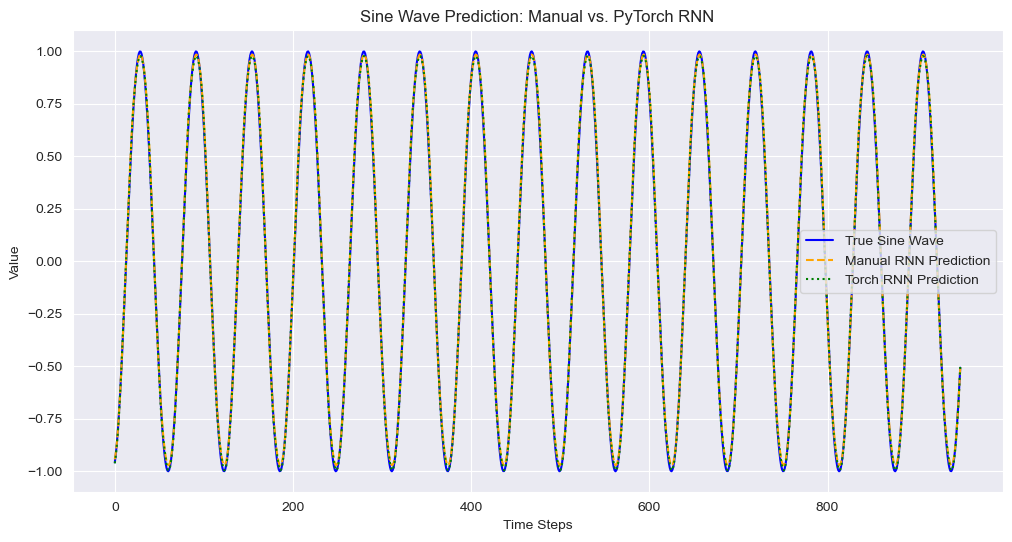

In [23]:
# Plotting results
pred_manual = []
pred_torch = []

with torch.no_grad():
    for i in range(X.size(0)):
        pred_manual.append(manual_model.forward(X[i]).detach().numpy()[-1])
        pred_torch.append(torch_model(X[i].unsqueeze(0)).detach().numpy())

pred_manual = np.array(pred_manual).flatten()
pred_torch = np.array(pred_torch).flatten()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y[seq_length:], label='True Sine Wave', color='blue')
plt.plot(pred_manual, label='Manual RNN Prediction', color='orange', linestyle='dashed')
plt.plot(pred_torch, label='Torch RNN Prediction', color='green', linestyle='dotted')
plt.legend()
plt.title('Sine Wave Prediction: Manual vs. PyTorch RNN')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.show()

### Example 2, variable frequency signal prediction with model validation
#### Creating the mixed signal Dataset
The result of mixing signals with different frequencies have a more complicated pattern than a sine wave, so a larger input sequence is needed or more hidden units on the hidden layer (larger size of the hidden layer).

In [3]:
# set device and reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


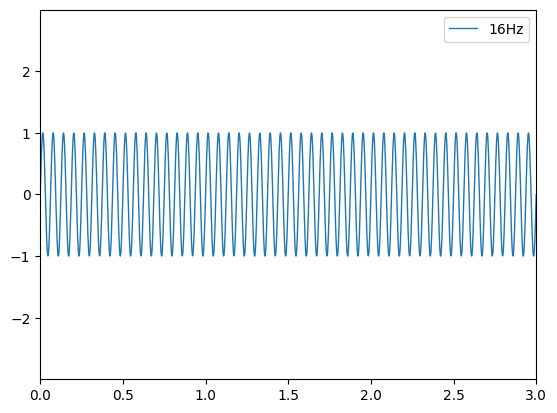

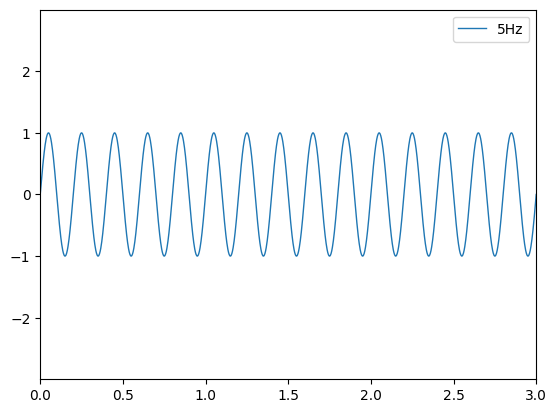

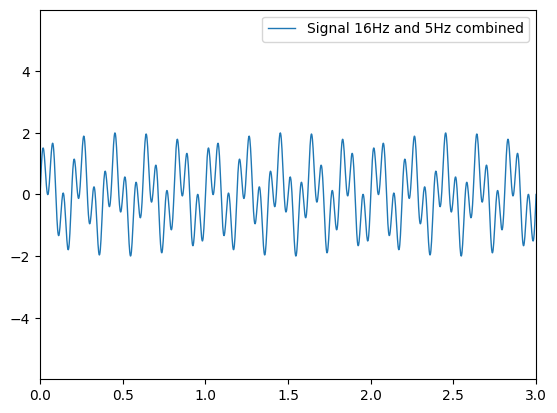

In [4]:
# Parameters for the signal frequencies and the amount of steps
signFreq1     = 16 #Hz
signFreq2     = 5 #Hz
steps         = 1500
range_start   = 0
range_end     = 3
npTime        = np.linspace(range_start,range_end,steps)
npSin1        = np.sin(2*np.pi*signFreq1*npTime)
npSin2        = np.sin(2*np.pi*signFreq2*npTime)
cleanSignal   = npSin1 + npSin2

seq_length = 50 # length of input sequence
input_size = 1 # one feature in for 1d regression
hidden_size = 34 # number of hidden units
output_size = 1 # one feature for regression



def plot_combined_signal():
    ## Sine frequency 1
    plt.margins(x=0, y=1)
    plt.plot(npTime,npSin1,linewidth=1,label=str(signFreq1)+"Hz")
    plt.legend()
    plt.show()
    
    ## Sine frequency 2
    plt.plot(npTime,npSin2,linewidth=1,label=str(signFreq2)+"Hz")
    plt.margins(x=0, y=1)
    plt.legend()
    plt.show()
    
    ## Combined signal, clean
    plt.plot(npTime,cleanSignal,linewidth=1,label="Signal "+str(signFreq1)+"Hz and "+str(signFreq2) + "Hz combined")
    plt.margins(x=0, y=1)
    plt.legend()
    plt.show()
    
plot_combined_signal()

Defining train and validation sets

In [6]:
# Create datasets
X_train, Y_train, X_val, Y_val = create_dataset(cleanSignal, seq_length, test_split=0.1)

# Convert to PyTorch tensors and reshape for RNN
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, seq_length, input_size).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).view(-1, seq_length, input_size).to(device)
Y_val = torch.tensor(Y_val, dtype=torch.float32).view(-1, 1).to(device)

### Defining the model
Architecture: RNN -> FCL 

In [7]:
# Compare with torch.nn.Module
# out = self.fc(out) 
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x) #<- the tanh activation function is used by default for the hidden updates.
        out = self.fc(out[:, -1, :])  # Use the last hidden state
        return out

### Training loop

In [9]:
# model hyperparameters
lr_2 = 0.0001
epochs_2 = 100

# Initialize and train RNN model
torch_model = RNNModel().to(device)
optimizer = optim.Adam(torch_model.parameters(), lr=lr_2)
criterion = nn.MSELoss()

# Training loop with validation
for epoch in range(epochs_2):
    torch_model.train()  # Set the model to training mode
    for i in range(X_train.size(0)):
        x_t = X_train[i].unsqueeze(0)  # Add batch dimension
        y_t = Y_train[i]

        # Forward pass
        outputs = torch_model(x_t)
        loss = criterion(outputs, y_t.unsqueeze(0))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    if epoch % 5 == 0:
        torch_model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for i in range(X_val.size(0)):
                x_v = X_val[i].unsqueeze(0)
                y_v = Y_val[i]
                val_outputs = torch_model(x_v)
                val_loss += criterion(val_outputs, y_v.unsqueeze(0)).item()

        val_loss /= X_val.size(0)  # Average validation loss
        print(f'Epoch {epoch}, Loss: {loss.item()}, Validation Loss: {val_loss}')

Epoch 0, Loss: 0.03640158474445343, Validation Loss: 0.04565230514240127
Epoch 5, Loss: 0.005575740244239569, Validation Loss: 0.004001541274680837
Epoch 10, Loss: 0.0026055341586470604, Validation Loss: 0.002767569209859646
Epoch 15, Loss: 0.0025780724827200174, Validation Loss: 0.0015360822471863905
Epoch 20, Loss: 0.002198369475081563, Validation Loss: 0.001107090517879881
Epoch 25, Loss: 0.0016412652330473065, Validation Loss: 0.000998086749073003
Epoch 30, Loss: 0.0012586606899276376, Validation Loss: 0.0007946802588236323
Epoch 35, Loss: 0.0009137241286225617, Validation Loss: 0.0006416163352986555
Epoch 40, Loss: 0.0006799074471928179, Validation Loss: 0.000549246762895205
Epoch 45, Loss: 0.0006909055518917739, Validation Loss: 0.0004763671298727284
Epoch 50, Loss: 0.0004022375214844942, Validation Loss: 0.0016250220651474576
Epoch 55, Loss: 3.308650047983974e-05, Validation Loss: 0.0003468768899253895
Epoch 60, Loss: 4.0610422047393513e-07, Validation Loss: 9.765310890804641e-0

### Plotting the results

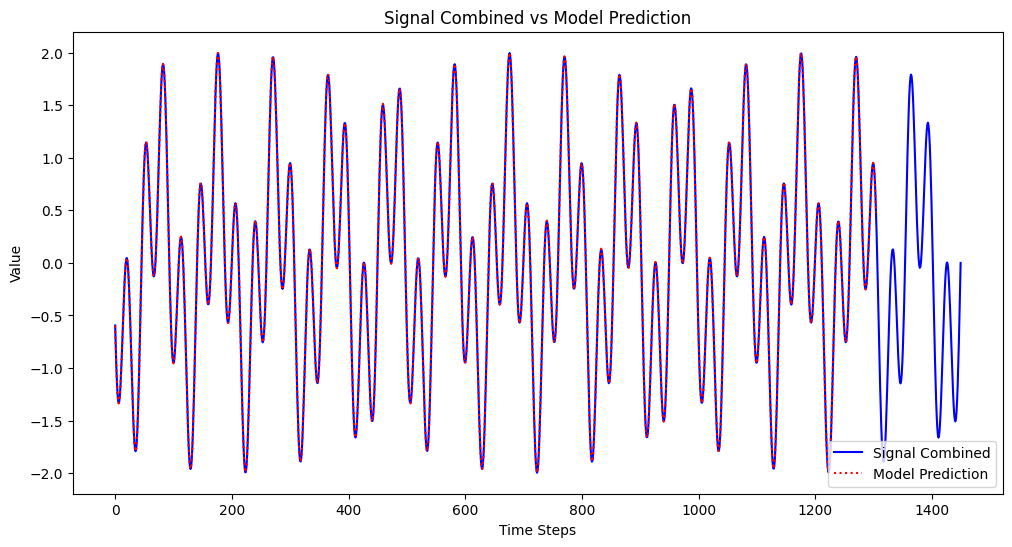

In [10]:
# Plotting results
pred_torch = []
with torch.no_grad():
    for i in range(X_train.size(0)):
        pred_torch.append(torch_model(X_train[i].unsqueeze(0)).cpu().numpy())
pred_torch = np.array(pred_torch).flatten()

# Plot the combined signal and predictions
plt.figure(figsize=(12, 6))
plt.plot(cleanSignal[seq_length:], label='Signal Combined', color='blue')
plt.plot(pred_torch, label='Model Prediction', color='red', linestyle='dotted')
plt.legend()
plt.title('Signal Combined vs Model Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.show()